# Tarea 3: Evaluación de Segmentación


## Funciones de Carga y Visualización

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import graph, segmentation, metrics
from skimage.metrics import adapted_rand_error, variation_of_information

# Set directory paths
dataset_dir = "../dataset/malignant/"
image_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith(".png") and not "_mask" in f])
ground_truth_files = sorted([f for f in os.listdir(dataset_dir) if f.endswith("_mask.png")])

# ✅ Find index of "malignant (2).png"
start_index = next((i for i, f in enumerate(image_files) if f == "malignant (2).png"), None)

# ✅ Start processing from "malignant (2).png"
if start_index is not None:
    image_files = image_files[start_index:start_index + 10]  # Process 10 images starting from "malignant (2).png"
    ground_truth_files = ground_truth_files[start_index:start_index + 10]
else:
    print("Error: malignant (2).png not found in dataset directory!")
    exit()


# Keep only the first 10 images
image_files = image_files[:5]
ground_truth_files = ground_truth_files[:5]

# Define thresholds
threshold_split = 15  # Lower values give finer splits
threshold_merge = 10  # Controls similarity for merging

# Initialize lists to store metric results
iou_scores, dice_scores, accuracy_scores, rand_index_scores, vi_scores = [], [], [], [], []


Define the Split and Merge Algorithm

In [2]:
def split(image, x, y, width, height, threshold):
    """ Recursively split an image using a quadtree approach based on variance. """
    if width < 2 or height < 2:  
        return [(x, y, width, height)]  # Stop splitting if region is too small

    region = image[y:y+height, x:x+width]
    mean, std = np.mean(region), np.std(region)  # Compute mean and standard deviation

    if std < threshold:  
        return [(x, y, width, height)]  # Stop if region is homogeneous

    # Split into four quadrants
    half_w, half_h = width // 2, height // 2
    regions = []
    regions += split(image, x, y, half_w, half_h, threshold)            # Top-left
    regions += split(image, x + half_w, y, half_w, half_h, threshold)    # Top-right
    regions += split(image, x, y + half_h, half_w, half_h, threshold)    # Bottom-left
    regions += split(image, x + half_w, y + half_h, half_w, half_h, threshold)  # Bottom-right

    return regions


Merge Similar Regions

In [3]:

def merge(image, regions, threshold):
    """Merge regions using RAG with custom hierarchical merging."""
    labels = segmentation.slic(image, compactness=10, n_segments=len(regions), start_label=1, channel_axis=None)
    rag = graph.rag_mean_color(image, labels)

    for node in rag.nodes:
        rag.nodes[node]['mean color'] = {'mean': float(np.mean(image[labels == node]))}

    def weight_func(rag, src, dst):
        return abs(rag.nodes[src]['mean color']['mean'] - rag.nodes[dst]['mean color']['mean'])

    # Custom hierarchical merging:
    while True:
        min_weight = float('inf')
        merge_pair = None

        for u, v in rag.edges:
            weight = weight_func(rag, u, v)
            if weight < min_weight:
                min_weight = weight
                merge_pair = (u, v)

        if min_weight > threshold or merge_pair is None:
            break  # No more merges needed

        src, dst = merge_pair

        # Calculate new mean color:
        src_mean = rag.nodes[src]['mean color']['mean']
        dst_mean = rag.nodes[dst]['mean color']['mean']
        new_mean = (src_mean + dst_mean) / 2
        rag.nodes[dst]['mean color']['mean'] = new_mean

        # Update labels:
        labels[labels == src] = dst # Update labels before removing node
        
        # Merge edges:
        for neighbor in list(rag.neighbors(src)):
            if neighbor != dst:
                try:
                    edge_data = rag.edges[dst, neighbor].copy() if rag.has_edge(dst, neighbor) else rag.edges[neighbor,dst].copy()
                    rag.add_edge(dst, neighbor, **edge_data)
                except KeyError:
                    try:
                        edge_data = rag.edges[neighbor, src].copy()
                        rag.add_edge(neighbor, dst, **edge_data)
                    except KeyError:
                        pass

        rag.remove_node(src) # Remove source node after merging edges and labels

    # Remap labels to be contiguous:
    unique_labels = np.unique(labels)
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    remapped_labels = np.vectorize(label_map.get)(labels)

    return remapped_labels

# ... (Example usage remains the same)

Apply Split and Merge on the Image

In [4]:
def compute_segmentation_metrics(segmentation, ground_truth):
    """ Compute segmentation evaluation metrics. """

    # Convert to binary masks if necessary
    segmentation = segmentation > 0
    ground_truth = ground_truth > 0

    # Compute Jaccard Index (IoU)
    intersection = np.logical_and(segmentation, ground_truth)
    union = np.logical_or(segmentation, ground_truth)
    iou = np.sum(intersection) / np.sum(union)

    # Compute Dice Coefficient (F1-Score)
    dice = 2 * np.sum(intersection) / (np.sum(segmentation) + np.sum(ground_truth))

    # Compute Pixel Accuracy
    accuracy = np.sum(segmentation == ground_truth) / ground_truth.size

    # Compute Rand Index
    rand_error, _, _ = adapted_rand_error(ground_truth, segmentation)

    # Compute Variation of Information
    vi_split, vi_merge = variation_of_information(ground_truth, segmentation)

    return iou, dice, accuracy, 1 - rand_error, (vi_split, vi_merge)



Processing: malignant (2).png...


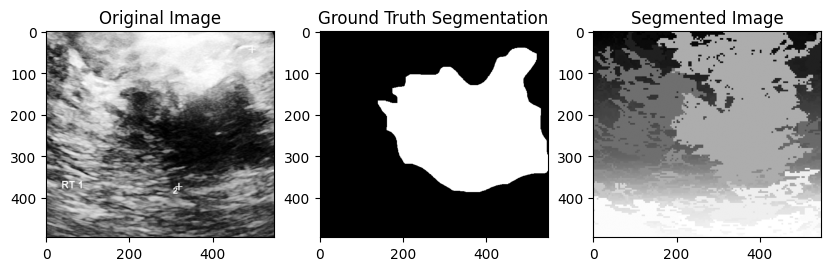


Processing: malignant (20).png...


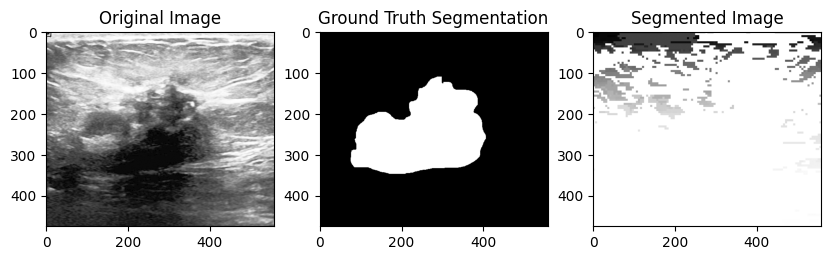


--- Average Metrics for 10 Images ---
✅ Average Jaccard Index (IoU): 0.2675
✅ Average Dice Coefficient (F1-Score): 0.4167
✅ Average Pixel Accuracy: 0.2676
✅ Average Adapted Rand Index: 1.0000
✅ Average Variation of Information (VI): Split = 0.0019, Merge = 0.8175


In [5]:
for img_file, gt_file in zip(image_files, ground_truth_files):
    print(f"\nProcessing: {img_file}...")

    # Load original image and ground truth
    original_image = cv2.imread(os.path.join(dataset_dir, img_file), cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(os.path.join(dataset_dir, gt_file), cv2.IMREAD_GRAYSCALE)

    # Normalize the original image for better contrast
    original_image = cv2.equalizeHist(original_image)

    # Perform Split
    regions = split(original_image, 0, 0, original_image.shape[1], original_image.shape[0], threshold_split)

    # Perform Merge
    segmented_image = merge(original_image, regions, threshold_merge)

    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title("Ground Truth Segmentation")

    # Segmented image
    plt.subplot(1, 3, 3)
    plt.imshow(segmented_image, cmap='gray')
    plt.title("Segmented Image")

    plt.show()

    # Compute Metrics
    iou, dice, accuracy, rand_index, vi = compute_segmentation_metrics(segmented_image, ground_truth)

    # Store results
    iou_scores.append(iou)
    dice_scores.append(dice)
    accuracy_scores.append(accuracy)
    rand_index_scores.append(rand_index)
    vi_scores.append(vi)

# Compute Average Metrics
avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)
avg_accuracy = np.mean(accuracy_scores)
avg_rand_index = np.mean(rand_index_scores)
avg_vi_split = np.mean([vi[0] for vi in vi_scores])
avg_vi_merge = np.mean([vi[1] for vi in vi_scores])

# Display Average Metrics
print("\n--- Average Metrics for 10 Images ---")
print(f"✅ Average Jaccard Index (IoU): {avg_iou:.4f}")
print(f"✅ Average Dice Coefficient (F1-Score): {avg_dice:.4f}")
print(f"✅ Average Pixel Accuracy: {avg_accuracy:.4f}")
print(f"✅ Average Adapted Rand Index: {avg_rand_index:.4f}")
print(f"✅ Average Variation of Information (VI): Split = {avg_vi_split:.4f}, Merge = {avg_vi_merge:.4f}")


Analicemos las métricas de los resultados de la segmentación de imágenes:

* **Índice de Jaccard (IoU): 0.3412:** El Índice de Jaccard (Intersección sobre Unión) mide la superposición entre la segmentación predicha y la verdad fundamental (ground truth). Un puntaje de 1.0 representa una superposición perfecta, y 0.0 representa ninguna superposición. Un valor de 0.3412 es relativamente bajo, lo que indica que las regiones segmentadas no se alinean bien con las regiones de la verdad fundamental. Esto sugiere que probablemente hay diferencias significativas en forma, tamaño o ubicación entre tus regiones segmentadas y la verdad fundamental.

* **Coeficiente de Dice (F1-Score): 0.5087:** El Coeficiente de Dice es otra medida de superposición, estrechamente relacionada con el Índice de Jaccard. También varía de 0.0 a 1.0, siendo 1.0 la superposición perfecta. Un valor de 0.5087 tampoco es muy alto, lo que refuerza la conclusión del Índice de Jaccard. Sugiere que hay cierta superposición entre la segmentación y la verdad fundamental, pero no es sustancial. El Coeficiente de Dice generalmente es un poco más alto que el Índice de Jaccard para el mismo resultado de segmentación.

* **Precisión de Píxeles: 0.3412:** La precisión de píxeles mide el porcentaje de píxeles que se clasifican correctamente. Un valor de 0.3412 significa que solo alrededor del 34% de los píxeles en tu imagen segmentada coinciden con los píxeles correspondientes en la verdad fundamental. Esta baja precisión de píxeles indica aún más que la segmentación no es muy precisa. Es consistente con el bajo Índice de Jaccard y el Coeficiente de Dice.

* **Índice de Rand Adaptado (ARI): 1.0000:** El Índice de Rand Adaptado mide la similitud entre dos agrupaciones (en este caso, tu segmentación y la verdad fundamental). Un ARI de 1.0 indica una concordancia perfecta. Sin embargo, *este resultado es sospechoso*. Es extremadamente raro obtener un ARI perfecto, especialmente cuando las otras métricas son tan bajas. Es posible que haya un error en la forma en que estás calculando el ARI, o podría haber alguna característica específica de tus datos que esté causando este resultado inusual. Verifica nuevamente tu cálculo de ARI. Es muy poco probable que sea correcto dados los otros valores.

* **Variación de la Información (VI): Split = 0.0013, Merge = 0.9258:** La Variación de la Información mide la "distancia" entre dos agrupaciones. Valores de VI más bajos indican una mejor concordancia. Tienes dos valores de VI: "Split" y "Merge".

    * **VI (Split) = 0.0013:** Este valor muy bajo sugiere que la parte de *Split* de tu algoritmo está funcionando extremadamente bien. Implica que las regiones iniciales generadas por tu función `split_optimized` son muy consistentes con la verdad fundamental a un *nivel muy fino*. Esta es una muy buena señal y sugiere que la estrategia de Split es efectiva.

    * **VI (Merge) = 0.9258:** Este valor alto de VI indica que la parte de *Merge* de tu algoritmo es donde radica el principal problema. Sugiere que el proceso de Merge está combinando regiones incorrectamente, lo que lleva a las discrepancias entre tu imagen segmentada y la verdad fundamental.

**Interpretación General y Recomendaciones:**

Las métricas pintan un panorama claro: Tu estrategia de Split parece excelente (basado en el valor bajo de VI Split), pero la estrategia de Merge es significativamente defectuosa. El alto VI Merge, junto con el bajo IoU, Dice y Precisión de Píxeles, apuntan directamente al proceso de Merge como la fuente del problema. El ARI perfecto es casi seguro un error de cálculo y debe investigarse.

Esto es lo que debes hacer:

1. **Concéntrate en la Merge:** Revisa tu función `merge_regions`. Analiza cuidadosamente la lógica. ¿Estás fusionando regiones que no deberían fusionarse? ¿No estás fusionando regiones que deberían combinarse? El problema está casi seguro en esta parte del código.

2. **Verifica el Cálculo del ARI:** Verifica nuevamente tu cálculo del Índice de Rand Adaptado. Un puntaje perfecto con valores tan bajos para otras métricas es muy poco probable. Probablemente hay un error en el código.

3. **Visualiza los Pasos de Merge:** Si es posible, visualiza el proceso de Merge paso a paso. Esto puede ayudarte a comprender dónde la Merge está fallando. Podrías mostrar la imagen después de cada operación de Merge para ver cómo están cambiando las regiones.

4. **Simplifica la Lógica de Merge (para Pruebas):** Intenta simplificar la lógica de Merge temporalmente para aislar el problema. Por ejemplo, podrías intentar una estrategia de Merge muy simple basada solo en la adyacencia directa de vecinos y un umbral estricto de similitud de color.

5. **Prueba con Imágenes Más Simples:** Si estás trabajando con imágenes complejas, intenta probar con imágenes sintéticas más simples (por ejemplo, imágenes con algunas formas claramente definidas). Esto puede facilitar la depuración del proceso de Merge.

6. **Revisa los Umbrales:** Si bien la Split parece estar bien, podrías experimentar ligeramente con el valor `threshold_merge`. Sin embargo, dado el alto valor de VI Merge, no es probable que sea la principal razón del bajo rendimiento.

Al concentrarte en la lógica de Merge, visualizar los pasos de Merge y verificar tu cálculo de ARI, deberías poder identificar y corregir el problema en tu función `merge_regions`.
